In [1]:
import torch
import os

In [2]:
torch.device("mps")
os.environ["THEANO_FLAGS"] = 'device=mps,floatX=float32,force_device=True'

In [3]:
# Load packages
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

In [4]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

In [5]:
results_folder = '/Users/tili/Desktop/CIIR/results/cell2location/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [6]:
# Load metadata
import pandas as pd
info = pd.read_csv('/Users/tili/Desktop/CIIR/data/ST-AR_Visium_samples_with file names.csv')

# Get sample ID
info['sampleID'] = info['Patientid'] + info['Tumor area']
info

,Patient,Patientid,Tumor area,Visium ID,Visum h5ad ID,name,type,sampleID
0,TD-2532-BCSA1,BCSA1,TumA1,V19T26-012_A1,200116_ST-AR_BC_A_B_V19T26-012_KT_V1-Spot00000...,a1.012,TNBC,BCSA1TumA1
1,TD-2532-BCSA1,BCSA1,TumA2,V19T26-012_B1,200116_ST-AR_BC_A_B_V19T26-012_KT_V2-Spot00000...,b1.012,TNBC,BCSA1TumA2
2,TD-2532-BCSA1,BCSA1,TumB1,V19T26-012_C1,200116_ST-AR_BC_A_B_V19T26-012_KT_V3-Spot00000...,c1.012,TNBC,BCSA1TumB1
3,TD-2532-BCSA1,BCSA1,TumB2,V19T26-012_D1,200116_ST-AR_BC_A_B_V19T26-012_KT_V4-Spot00000...,d1.012,TNBC,BCSA1TumB2
4,TD-2532-BCSA2,BCSA2,TumB1,V10F24-112_C1,200616_BC-SA2_V10F24-112_KT.C1-Spot000001.h5ad,c1.112,HER2+,BCSA2TumB1
5,TD-2532-BCSA2,BCSA2,TumB2,V10F24-112_D1,200616_BC-SA2_V10F24-112_KT.D1-Spot000001.h5ad,d1.112,HER2+,BCSA2TumB2
6,TD-2532-BCSA2,BCSA2,TumC1,V10F24-113_A1,200715_BC_SA2_C_D_V10F24-113.A1-Spot000001.h5ad,a1.113,HER2+,BCSA2TumC1
7,TD-2532-BCSA2,BCSA2,TumC2,V10F24-113_B1,200715_BC_SA2_C_D_V10F24-113.B1-Spot000001.h5ad,b1.113,HER2+,BCSA2TumC2
8,TD-2532-BCSA2,BCSA2,TumD1,V10F24-113_C1,200715_BC_SA2_C_D_V10F24-113.C1-Spot000001.h5ad,c1.113,HER2+,BCSA2TumD1
9,TD-2532-BCSA2,BCSA2,TumD2,V10F24-113_D1,200715_BC_SA2_C_D_V10F24-113.D1-Spot000001.h5ad,d1.113,HER2+,BCSA2TumD2


In [7]:
# Select one sample from each subtype to train the reference map
info1 = info.iloc[[0,4]]
info1

,Patient,Patientid,Tumor area,Visium ID,Visum h5ad ID,name,type,sampleID
0,TD-2532-BCSA1,BCSA1,TumA1,V19T26-012_A1,200116_ST-AR_BC_A_B_V19T26-012_KT_V1-Spot00000...,a1.012,TNBC,BCSA1TumA1
4,TD-2532-BCSA2,BCSA2,TumB1,V10F24-112_C1,200616_BC-SA2_V10F24-112_KT.C1-Spot000001.h5ad,c1.112,HER2+,BCSA2TumB1


/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


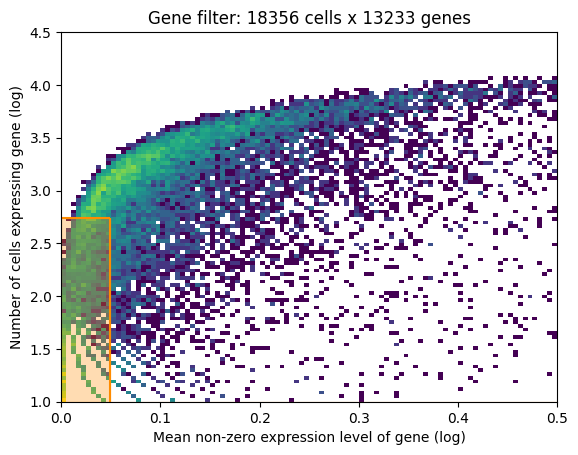

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 250/250: 100%|█| 250/250 [15:05<00:00,  3.61s/it, v_num=1, elbo_train=1.02

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|█| 250/250 [15:05<00:00,  3.62s/it, v_num=1, elbo_train=1.02
Sampling global variables, sample: 100%|██████| 999/999 [00:47<00:00, 21.17it/s]


/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


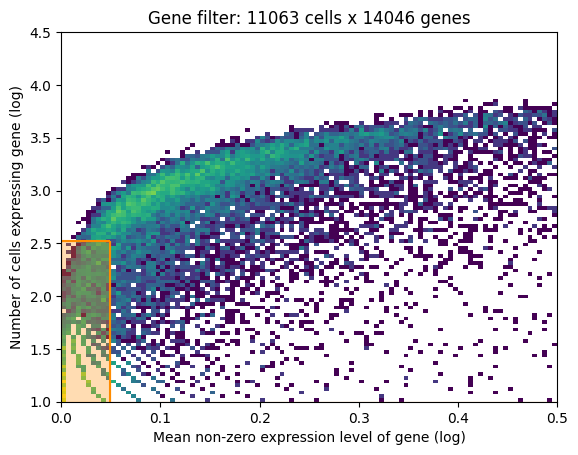

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 250/250: 100%|█| 250/250 [09:41<00:00,  2.34s/it, v_num=1, elbo_train=7.03

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|█| 250/250 [09:41<00:00,  2.33s/it, v_num=1, elbo_train=7.03
Sampling global variables, sample: 100%|██████| 999/999 [00:49<00:00, 20.24it/s]


In [8]:
# Create and Save reference map
for row in info1.iterrows():
    id = row[1]['sampleID']
    Type = row[1]['type']
    if (Type == "TNBC"):
        # Read single cell reference data
        adata_ref = sc.read(
            f'/Users/tili/Desktop/CIIR/data/Wu_etal_2021_BRCA_scRNASeq/cell2location/tnbc.h5ad')
    else:
        adata_ref = sc.read(
            f'/Users/tili/Desktop/CIIR/data/Wu_etal_2021_BRCA_scRNASeq/cell2location/her2.h5ad')

    # Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. 
    # We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes 
    # while removing most of the uninformative genes.
    from cell2location.utils.filtering import filter_genes
    selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

    # filter the object
    adata_ref = adata_ref[:, selected].copy()

    # Estimation of reference cell type signatures (NB regression) 
    # The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.
    # prepare anndata for the regression model
    cell2location.models.RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch
                        batch_key='orig.ident', 
                        # cell type, covariate used for constructing signatures
                        labels_key='celltype_minor'
                       )

    # create the regression model
    from cell2location.models import RegressionModel
    mod = RegressionModel(adata_ref) 

    # Training model.
    # Now we train the model to estimate the reference cell type signatures.
    # Note that to achieve convergence on your data (=to get stabilization of the loss) you may need to increase max_epochs=250 (See below).
    # Also note that here we are using batch_size=2500 which is much larger than scvi-tools default and perform training on all cells 
    # in the data (train_size=1) - both parameters are defaults.
    mod.train(max_epochs=250)

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_ref = mod.export_posterior(
        adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
    )

    if (Type == "TNBC"):
        adata_ref_tnbc = adata_ref
    else:
        adata_ref_her2 = adata_ref


In [11]:
# Select one sample from each subtype to train the reference map
info2 = info.iloc[4:23]
info2

,Patient,Patientid,Tumor area,Visium ID,Visum h5ad ID,name,type,sampleID
4,TD-2532-BCSA2,BCSA2,TumB1,V10F24-112_C1,200616_BC-SA2_V10F24-112_KT.C1-Spot000001.h5ad,c1.112,HER2+,BCSA2TumB1
5,TD-2532-BCSA2,BCSA2,TumB2,V10F24-112_D1,200616_BC-SA2_V10F24-112_KT.D1-Spot000001.h5ad,d1.112,HER2+,BCSA2TumB2
6,TD-2532-BCSA2,BCSA2,TumC1,V10F24-113_A1,200715_BC_SA2_C_D_V10F24-113.A1-Spot000001.h5ad,a1.113,HER2+,BCSA2TumC1
7,TD-2532-BCSA2,BCSA2,TumC2,V10F24-113_B1,200715_BC_SA2_C_D_V10F24-113.B1-Spot000001.h5ad,b1.113,HER2+,BCSA2TumC2
8,TD-2532-BCSA2,BCSA2,TumD1,V10F24-113_C1,200715_BC_SA2_C_D_V10F24-113.C1-Spot000001.h5ad,c1.113,HER2+,BCSA2TumD1
9,TD-2532-BCSA2,BCSA2,TumD2,V10F24-113_D1,200715_BC_SA2_C_D_V10F24-113.D1-Spot000001.h5ad,d1.113,HER2+,BCSA2TumD2
10,TD-2532-BCSA2,BCSA2,TumE1,V10F24-114_C1,200715_BC_SA2_D_E_V10F24-114.C1-Spot000001.h5ad,c1.114,HER2+,BCSA2TumE1
11,TD-2532-BCSA2,BCSA2,TumE2,V10F24-114_D1,200715_BC_SA2_D_E_V10F24-114.D1-Spot000001.h5ad,d1.114,HER2+,BCSA2TumE2
12,TD-2532-BCSA3,BCSA3,TumA1,V19T26-031_D1,200219_BC_SA3_V19T26-031_CE_V4-Spot000001.h5ad,d1.031,HER2+,BCSA3TumA1
13,TD-2532-BCSA3,BCSA3,TumA2,V19T26-031_C1,200219_BC_SA3_V19T26-031_CE_V3-Spot000001.h5ad,c1.031,HER2+,BCSA3TumA2


In [12]:
# Cell2location mapping
for row in info2.iterrows():
    id = row[1]['sampleID']
    Type = row[1]['type']
    if (Type == "TNBC"):
        # Read single cell reference data
        adata_ref = adata_ref_tnbc
    else:
        adata_ref = adata_ref_her2

    # Read visium data
    adata_vis = sc.read(f'/Users/tili/Desktop/CIIR/data/ST_data/cell2location/{id}.h5ad')

    # Extracting reference cell types signatures as a pd.DataFrame.
    # All parameters of the a Negative Binomial regression model are exported into reference anndata object, 
    # however for spatial mapping we just need the estimated expression of every gene in every cell type. 
    # Here we extract that from standard output:
    # export estimated expression in each cluster
    if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
        inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_ref.uns['mod']['factor_names']]].copy()
    else:
        inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_ref.uns['mod']['factor_names']]].copy()
    inf_aver.columns = adata_ref.uns['mod']['factor_names']
    inf_aver.iloc[0:5, 0:5]

    # Cell2location: spatial mapping 
    # Find shared genes and prepare anndata. Subset both anndata and reference signatures:
    intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
    adata_vis = adata_vis[:, intersect].copy()
    inf_aver = inf_aver.loc[intersect, :].copy()

    # prepare anndata for cell2location model
    cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="orig.ident")

    # create and train the model
    mod = cell2location.models.Cell2location(
        adata_vis, cell_state_df=inf_aver, 
        # the expected average cell abundance: tissue-dependent 
        # hyper-prior which can be estimated from paired histology:
        #N_cells_per_location=50, # For BCSA1
        N_cells_per_location=20, # For BCSA2-4
        # hyperparameter controlling normalisation of
        # within-experiment variation in RNA detection:
        detection_alpha=20
    ) 

    # Training cell2location
    mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
         )

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_vis = mod.export_posterior(
        adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
    )

    # Save the prediction results as csv files
    path = "/Users/tili/Desktop/CIIR/results/cell2location/" + id + "_q05_20_cells_per_spot.csv"
    adata_vis.obsm['q05_cell_abundance_w_sf'].to_csv(path)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [4:05:27<00:00,  2.07it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [4:05:27<00:00,  2.04it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:01<00:00, 16.15it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [4:24:24<00:00,  1.90it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [4:24:24<00:00,  1.89it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:07<00:00, 14.79it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [5:34:17<00:00,  1.49it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [5:34:17<00:00,  1.50it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:23<00:00, 11.95it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [5:53:37<00:00,  1.41it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [5:53:37<00:00,  1.41it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:29<00:00, 11.20it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [6:18:07<00:00,  1.31it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [6:18:07<00:00,  1.32it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:36<00:00, 10.39it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [5:16:40<00:00,  1.58it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [5:16:40<00:00,  1.58it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:17<00:00, 12.89it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [6:15:25<00:00,  1.34it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [6:15:25<00:00,  1.33it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:44<00:00,  9.58it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [6:15:28<00:00,  1.33it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [6:15:28<00:00,  1.33it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:44<00:00,  9.55it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [5:25:22<00:00,  1.47it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [5:25:22<00:00,  1.54it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:29<00:00, 11.17it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [5:26:54<00:00,  1.54it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [5:26:54<00:00,  1.53it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:23<00:00, 11.90it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [4:34:20<00:00,  1.80it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [4:34:20<00:00,  1.82it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:10<00:00, 14.09it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [4:44:00<00:00,  1.81it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [4:44:00<00:00,  1.76it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:16<00:00, 13.04it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [5:44:42<00:00,  1.47it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [5:44:42<00:00,  1.45it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:28<00:00, 11.33it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [5:46:13<00:00,  1.51it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [5:46:13<00:00,  1.44it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:28<00:00, 11.26it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [4:58:36<00:00,  1.72it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [4:58:36<00:00,  1.67it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:24<00:00, 11.88it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [5:11:44<00:00,  1.58it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [5:11:44<00:00,  1.60it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:27<00:00, 11.44it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [4:42:53<00:00,  1.75it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [4:42:53<00:00,  1.77it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:19<00:00, 12.55it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [4:01:41<00:00,  2.10it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [4:01:41<00:00,  2.07it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:06<00:00, 14.99it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/Users/tili/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The num

Epoch 30000/30000: 100%|█| 30000/30000 [3:41:01<00:00,  2.26it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [3:41:01<00:00,  2.26it/s, v_num=1, elbo_
Sampling global variables, sample: 100%|██████| 999/999 [01:01<00:00, 16.22it/s]
